# Analysis

## Setup

### Imports

In [1]:
import os
import pandas as pd
import pyarrow as pa
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize, rgb2hex, CenteredNorm
from great_tables import GT, style, from_column, loc, html

### Defined Functions

In [2]:
def queryDB(query):
    """
    Function that takes string as a query for the database.
    Input: String query.
    Output: Dataframe of table produced by query.
    """
    # Get the path to the database.
    script_dir = os.getcwd()
    db_path = os.path.join(script_dir, 'data', 'smt_2025.db')

    # Run query.
    with db.connect(db_path) as con:
        df = con.sql(query).df()
    
    return df

### Constants

In [3]:
# List of unicode star icons from 0 to 5 stars.
STAR_ICONS = ['\U00002606 \U00002606 \U00002606 \U00002606 \U00002606',
              '\U00002605 \U00002606 \U00002606 \U00002606 \U00002606',
              '\U00002605 \U00002605 \U00002606 \U00002606 \U00002606', 
              '\U00002605 \U00002605 \U00002605 \U00002606 \U00002606',
              '\U00002605 \U00002605 \U00002605 \U00002605 \U00002606',
              '\U00002605 \U00002605 \U00002605 \U00002605 \U00002605']

# Color scale [Blue, Gray, Red], and color map.
COLORS = ['#001C48', '#E2E9EB', '#AB0520']
COLOR_MAP = LinearSegmentedColormap.from_list('az_scale', COLORS)

### Data

In [4]:
# Bring in csv's.
probabilities = pd.read_csv('data/catch_probabilities.csv')
play_metrics = pd.read_csv('data/play_metrics.csv')
route_metrics = pd.read_csv('data/route_metrics.csv')
route_marginals = pd.read_csv('data/route_marginals.csv')
player_metrics = pd.read_csv('data/player_metrics.csv')

## Outs Above Average (OAA)

### Star Levels and Calculating OAA

The catch probability of a play determines the difficulty of the play. The lower the catch probability, the higher the difficulty to make the catch. Statcast's [Star](https://baseballsavant.mlb.com/leaderboard/catch_probability) system buckets catches within specific catch probability ranges, where the easiest to catch (+95%) is given a rating of 0 Stars and the highest difficulty of catch (0 - 25%) is given 5 Stars.

In [5]:
# Initialize buckets for features.
star_buckets = ['>95%', '91-95%', '76-90%', '51-75%', '26-50%', '0-25%']

# Create great table for figure.
star_probs = pd.DataFrame({'star_level': STAR_ICONS,
                           'catch_prob': star_buckets})

# Great table for paper.
(GT(star_probs)
  # Header.
 .tab_header('Catch Probability Buckets')
  # Labels
 .cols_label(star_level = 'Star Level',
              catch_prob = 'Catch Probability')
  # Polish.
 .cols_align('center'))

GT(_tbl_data=  star_level catch_prob
0  ☆ ☆ ☆ ☆ ☆       >95%
1  ★ ☆ ☆ ☆ ☆     91-95%
2  ★ ★ ☆ ☆ ☆     76-90%
3  ★ ★ ★ ☆ ☆     51-75%
4  ★ ★ ★ ★ ☆     26-50%
5  ★ ★ ★ ★ ★      0-25%, _body=<great_tables._gt_data.Body object at 0x0000029BFE64FA50>, _boxhead=Boxhead([ColInfo(var='star_level', type=<ColInfoTypeEnum.default: 1>, column_label='Star Level', column_align='center', column_width=None), ColInfo(var='catch_prob', type=<ColInfoTypeEnum.default: 1>, column_label='Catch Probability', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000029BDA203ED0>, _spanners=Spanners([]), _heading=Heading(title='Catch Probability Buckets', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000029B80283F10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, category='heading', type='value', value='initial'), heading_subtitle_font_size=OptionsI

Now to use the probabilities determined by the catch probability model to bucket the plays into different Star Levels.

In [6]:
# Query to attach catch probability to to the play metrics, bucket plays into star levels.
query = """
-- CTE calculates oaa for each play.
WITH oaa AS (SELECT pm.play_key,
                    ROUND(p.probability, 3) AS catch_proba,
                    ROUND(p.catch - ROUND(p.probability, 3), 2) AS oaa
             FROM play_metrics AS pm
             JOIN probabilities AS p
             ON pm.play_key = p.play_key)
-- Table that has play metrics with oaa information added.
SELECT pm.*,
       o.catch_proba,
       o.oaa,
       CASE
           WHEN catch_proba > 0.95 THEN '0 Star'
           WHEN catch_proba > 0.91 AND catch_proba <= 0.95 THEN '1 Star'
           WHEN catch_proba > 0.76 AND catch_proba <= 0.91 THEN '2 Star'
           WHEN catch_proba > 0.51 AND catch_proba <= 0.76 THEN '3 Star'
           WHEN catch_proba > 0.26 AND catch_proba <= 0.51 THEN '4 Star'
           ELSE '5 Star'
      END AS star
FROM play_metrics AS pm
JOIN oaa AS o
ON pm.play_key = o.play_key
"""

# Return table with route metrics with OAA and buckets attached.
route_metrics_oaa = queryDB(query)

### Opportunity Space and Play Difficulty

Continuing the exploration of the relationship between the distance an outfielder needs to travel to catch a ball and the amount of time that they have to cover that distance from the Tom Tango's *The History of Fielding*, and this project's *Data_Engineering* Notebook, let's look at the levels of difficulty within the opportunity spaces of this sample of Minor League outfielders.

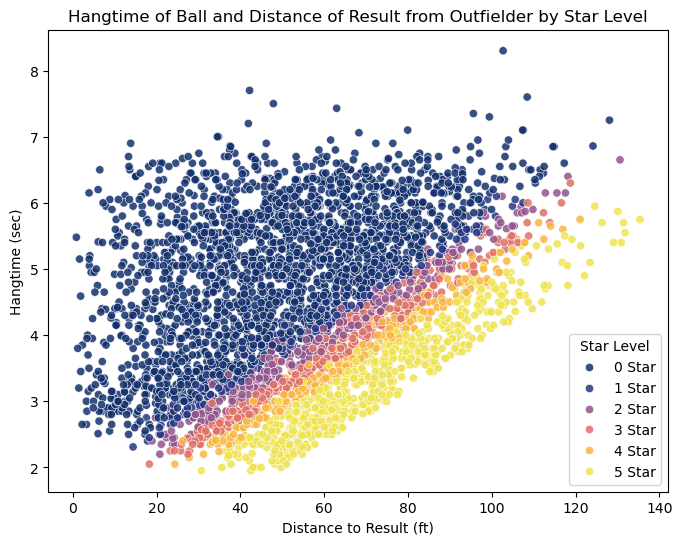

In [7]:
# Star order.
star_order = ['0 Star', '1 Star', '2 Star', '3 Star', '4 Star', '5 Star']

# Apply Magma palette to Star level.
star_palette = {'0 Star': '#13306dff', 
                '1 Star': '#253582ff',
                '2 Star': '#90548bff',
                '3 Star': '#de7065ff',
                '4 Star': '#f9b641ff',
                '5 Star': '#efe350ff'}

# Plot.
plt.figure(figsize = (8, 6))
sns.scatterplot(data = route_metrics_oaa, x = 'dist_to_result', y = 'hangtime', hue = 'star', hue_order = star_order,
                palette = star_palette, alpha = .85)

plt.title('Hangtime of Ball and Distance of Result from Outfielder by Star Level')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')
plt.legend(loc = 'lower right', title = 'Star Level')

There is a clear delination between the Star Levels here, which makes sense. The longer distances over a shorter amount of time are more difficult to catch, with the 5 Star plays being the ones that require the outfielder to cover the most ground in the shortest amount of time. 

Let's reduce the noise a bit and remove the 0 to 1 Star plays as they seem to have a high chance of success. Then, because we are dealing with distance over time, lets take a look at the median max sprint speed of the fielders in this population.

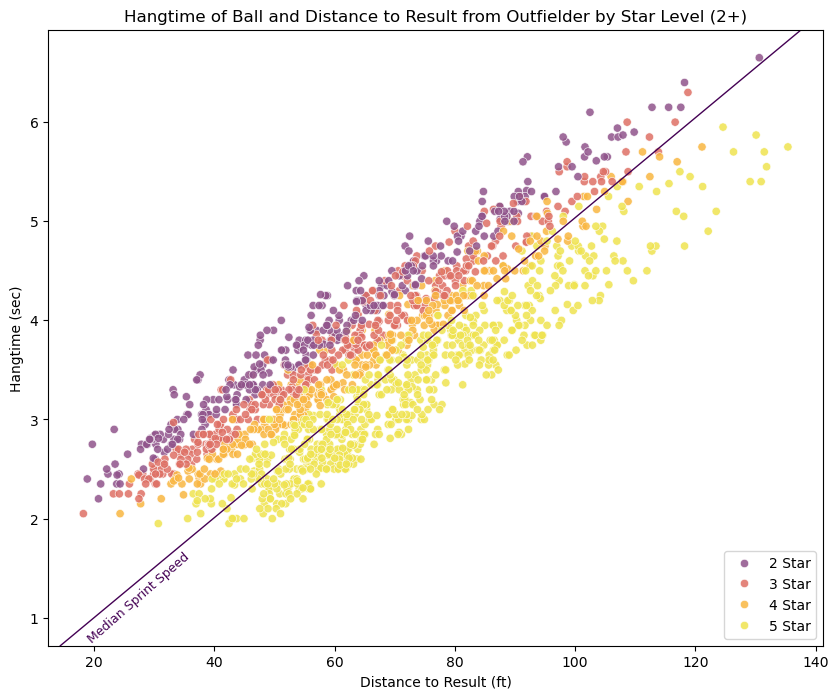

In [8]:
# Population median max sprint speeds.
sprint_speed_med = round(route_metrics_oaa['max_sprint'].median(), 2)

# Remove 2 star from hue list.
star_order2 = star_order[2:]

# Remove 0 star
opp_space = route_metrics_oaa[~route_metrics_oaa['star'].isin(['0 Star', '1 Star'])]

# Plot
plt.figure(figsize = (10, 8))
sns.scatterplot(data = opp_space, x = 'dist_to_result', y = 'hangtime', hue = 'star',  hue_order = star_order2, 
                palette = star_palette, alpha = .85)
# Sprint speed line.
plt.axline((20,1), slope = 1 / sprint_speed_med, color = '#440154ff', linewidth = 1)

# Labels.
plt.title('Hangtime of Ball and Distance to Result from Outfielder by Star Level (2+)')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')

# Sprint speed line text.
plt.text(18.5, .75, 'Median Sprint Speed', rotation = 41.2, color = '#440154ff', fontsize = 9)

# Polish
plt.legend(loc = 'lower right')

### Average Metrics of Various Difficulty Plays

The median sprint speed for the population is just under 20 feet per second (19.8). Overlaying this over the different star level plays, it would appear that the average fielder would have the ability to make a play on the ball and create an out. The median sprint speed also suggests that even some of the 5 Star plays are capable of being caught by the average fielder. However, this assumption expects that the fielder would be sprinting from start of the play and traveling at that speed at a constant rate from the moment the ball is released from the pitcher.

Let's dive deeper and look at the average metrics of the different play levels such as:

**dist_react**: The distance the fielder travels in the first 1.5 seconds.

**max_sprint**: The average speed of the top third 1 second windows speeds.

**route_dist**: The distance the fielder traveled during the route.

**int_pct**: The percent of route in distance that the fielder traveled at or above their `max_sprint`.

**oaa_added**: The amount of OAA that the play generates.

In [9]:
# Query to get the average metrics for each star level
query = """
SELECT oaa.star,
       ROUND(AVG(rm.t_dist_react), 2) AS mean_dist_react,
       ROUND(AVG(rm.max_sprint), 2) AS mean_max_sprint,
       ROUND(AVG(rm.int_pct), 2) AS mean_int_pct,
       ROUND(AVG(oaa.oaa), 2) AS mean_oaa_added
FROM route_metrics_oaa AS oaa
JOIN route_metrics AS rm
ON oaa.play_key = rm.play_key
WHERE oaa.catch = True
GROUP BY oaa.star
ORDER BY oaa.star
"""

star_means = queryDB(query)

star_means

,star,mean_dist_react,mean_max_sprint,mean_int_pct,mean_oaa_added
0,0 Star,4.43,16.50,0.08,0.01
1,1 Star,5.73,20.42,0.19,0.07
2,2 Star,6.16,21.78,0.27,0.15
3,3 Star,6.46,23.54,0.43,0.35
4,4 Star,7.29,25.23,0.53,0.59
5,5 Star,8.93,26.96,0.65,0.80


In [10]:
# Add icons to the dataframe.
star_means['icons'] = STAR_ICONS

# Create great table for figure.
(GT(star_means)
  # Title.
 .tab_header('Average Metrics of Out Producing Plays per Star Level')
  # Move icons to front.
 .cols_move_to_start(columns = ['icons'])
  # Format percents.
 .fmt_percent(columns = ['mean_int_pct'],
              decimals = 0)
  # Add borders.
 .tab_style(style.borders(sides = ['top', 'left', 'right'], 
                          color = '#AB0520',
                          weight = '2px'),
                          locations = loc.body(rows =[3],
                                               columns = 'mean_int_pct'))
 .tab_style(style.borders(sides = ['left', 'right'],
                          color = '#AB0520',
                          weight = '2px'),
                          locations = loc.body(rows = [3, 4, 5],
                                               columns = 'mean_int_pct'))
 .tab_style(style.borders(sides = 'bottom',
                          color = '#AB0520',
                          weight = '2px'),
                          locations = loc.body(rows = [5],
                                               columns = 'mean_int_pct'))
  # Add column labels.
 .cols_label(icons = 'Star Level',
             mean_dist_react = html('React Distance<br>(ft)'),
             mean_max_sprint = html('Max Sprint Speed<br>(ft/sec)'),
             mean_int_pct = html('Intensity<br>%'),
             mean_oaa_added = html('OAA<br>Added'))
  # Polish.
 .cols_align('center')
 .cols_hide(['star'])
 .show())

Average Metrics of Out Producing Plays per Star Level 
 
 
 Star Level 
 React Distance (ft) 
 Max Sprint Speed (ft/sec) 
 Intensity % 
 OAA Added 
 
 
 
 
 ☆ ☆ ☆ ☆ ☆ 
 4.43 
 16.5 
 8% 
 0.01 
 
 
 ★ ☆ ☆ ☆ ☆ 
 5.73 
 20.42 
 19% 
 0.07 
 
 
 ★ ★ ☆ ☆ ☆ 
 6.16 
 21.78 
 27% 
 0.15 
 
 
 ★ ★ ★ ☆ ☆ 
 6.46 
 23.54 
 43% 
 0.35 
 
 
 ★ ★ ★ ★ ☆ 
 7.29 
 25.23 
 53% 
 0.59 
 
 
 ★ ★ ★ ★ ★ 
 8.93 
 26.96 
 65% 
 0.8

There are significant differences in the amount of distance covered in the react phase, the sprint speed, the route intensity of lower difficulty and the most difficult plays. Most notably the increase in route intensity between 2 and 3 Star plays has a difference of 16% and for success on 3+ Star plays the average outfielder traveled at least 43% of the route at intensity. From the relationship between distance needed to catch a ball and the time it takes to get to the right spot, it is known that outfielders need to move fast, but this also indicates that they need to move fast for longer intervals of time.

### Fielding Percentage for High Intensity Routes

How do high intensity routes affect fielding percentage?

In [11]:
# Query to get fielding percentages for all plays, plays with high route intensity, and total outs when fielder has high route intensity.
query = """
WITH star_all AS (SELECT star,
                         COUNT(*) AS opp,
                         SUM(catch) AS out,
                         ROUND(SUM(catch) / COUNT(*), 3) AS out_pct
                  FROM route_metrics_oaa
                  GROUP BY star
                  ORDER BY star),
-- CTE with percent of catches when fielder has a route intensity of 40%.
star_int AS (SELECT oaa.star,
                    COUNT(*) AS opp_int,
                    SUM(oaa.catch) AS out_int,
                    ROUND(SUM(oaa.catch) / COUNT(*), 3) AS out_pct_int,
             FROM route_metrics_oaa AS oaa
             JOIN route_metrics AS rm
             ON oaa.play_key = rm.play_key
             WHERE rm.int_pct > .4
             GROUP BY star),
-- CTE to aggregate over all start levels.
star_agg AS (SELECT 'Total' AS star,
                     SUM(sa.opp),
                     SUM(sa.out),
                     ROUND(SUM(sa.out)/ SUM(sa.opp), 3),
                     SUM(se.opp_int),
                     SUM(se.out_int),
                     ROUND(SUM(se.out_int) / SUM(se.opp_int), 3),
                     ROUND(SUM(se.out_int) / SUM(sa.out), 3)
             FROM star_int AS se
             JOIN star_all AS sa
             ON se.star = sa.star),
-- CTE bringing star level numbers together.
star_info AS (SELECT sa.star,
                     sa.opp AS opp_all,
                     sa.out AS out_all,
                     sa.out_pct AS out_pct_all,
                     se.opp_int,
                     se.out_int,
                     se.out_pct_int,
                     ROUND(se.out_int / sa.out, 3) AS pct_int_outs
              FROM star_all AS sa
              JOIN star_int AS se
              ON sa.star = se.star
              ORDER BY sa.star)
-- Table with per star level information and aggreagated star level metrics.
SELECT *
FROM star_info
UNION
SELECT *
FROM star_agg
ORDER BY star
"""

# Returns table with fielding percentages, and total outs at high intensity.
stars_int = queryDB(query)

# Add icons to the dataframe.
star_icon_total = STAR_ICONS + ['Total']
stars_int['icons'] = star_icon_total

stars_int

,star,opp_all,out_all,out_pct_all,opp_int,out_int,out_pct_int,pct_int_outs,icons
0,0 Star,2196.0,2167.0,0.987,134.0,127.0,0.948,0.059,☆ ☆ ☆ ☆ ☆
1,1 Star,193.0,183.0,0.948,41.0,40.0,0.976,0.219,★ ☆ ☆ ☆ ☆
2,2 Star,321.0,288.0,0.897,99.0,89.0,0.899,0.309,★ ★ ☆ ☆ ☆
3,3 Star,358.0,264.0,0.737,186.0,155.0,0.833,0.587,★ ★ ★ ☆ ☆
4,4 Star,296.0,118.0,0.399,172.0,88.0,0.512,0.746,★ ★ ★ ★ ☆
5,5 Star,665.0,18.0,0.027,310.0,17.0,0.055,0.944,★ ★ ★ ★ ★
6,Total,4029.0,3038.0,0.754,942.0,516.0,0.548,0.170,Total


In [12]:
# Create great table for fielding percentage for different intensity levels figure.
(GT(stars_int)
  # Title.
 .tab_header('Outfield Fielding Percentage per Star Level and High Intensity')
 # Move icons to the front.
 .cols_move_to_start(columns = ['icons'])
  # All plays spanner.
 .tab_spanner(label = 'All Plays',
              columns = ['opp_all', 'out_all', 'out_pct_all'])
  # Intensity plays spanner.
 .tab_spanner(label = 'High Intensity',
              columns = ['opp_int', 'out_int', 'out_pct_int'])
  # Intensity outs.
 .tab_spanner(label = 'High Intensity Outs',
              columns = 'pct_int_outs')
  # Format percents and numbers.
 .fmt_percent(columns = ['out_pct_all', 'out_pct_int', 'pct_int_outs'],
              decimals = 1)
 .fmt_number(columns = ['opp_all','out_all', 'opp_int','out_int'],
             decimals = 0)
  # Add borders to divide columns.
  # Black.
 .tab_style(style.borders(['right'], 
                          color = 'black'),
            locations = loc.body([0, 3, 6]))
  # Red.
 .tab_style(style.borders(['top'],
                          color = '#AB0520',
                          weight = '2px'),
            locations = loc.body(rows = [3],
                                 columns = ['pct_int_outs']))
 .tab_style(style.borders(['left', 'right'],
                          color = '#AB0520',
                          weight = '3px'),
            locations = loc.body(rows = [3, 4, 5],
                                 columns = ['pct_int_outs']))
 .tab_style(style.borders(['bottom'],
                          color = '#AB0520',
                          weight = '3px'),
            locations = loc.body(rows = [5],
                                 columns = ['pct_int_outs']))
  # Add borders to deliniate Totals.
 .tab_style(style.borders(['top'],
                          color = 'black',
                          weight = '4px'),
            locations = loc.body(rows = [6]))
  # Add column labels.
 .cols_label(icons = 'Star Level',
             opp_all = 'Opps',
             out_all = 'Outs',
             out_pct_all = '%',
             opp_int = 'Opps',
             out_int = 'Outs',
             out_pct_int = '%',
             pct_int_outs = '%')
  # Polish
 .cols_hide(['star'])
 .cols_align('center')
 .show())

Outfield Fielding Percentage per Star Level and High Intensity 
 
 
 Star Level 
 
 All Plays 
 
 
 High Intensity 
 
 
 High Intensity Outs 
 
 
 
 Opps 
 Outs 
 % 
 Opps 
 Outs 
 % 
 % 
 
 
 
 
 ☆ ☆ ☆ ☆ ☆ 
 2,196 
 2,167 
 98.7% 
 134 
 127 
 94.8% 
 5.9% 
 
 
 ★ ☆ ☆ ☆ ☆ 
 193 
 183 
 94.8% 
 41 
 40 
 97.6% 
 21.9% 
 
 
 ★ ★ ☆ ☆ ☆ 
 321 
 288 
 89.7% 
 99 
 89 
 89.9% 
 30.9% 
 
 
 ★ ★ ★ ☆ ☆ 
 358 
 264 
 73.7% 
 186 
 155 
 83.3% 
 58.7% 
 
 
 ★ ★ ★ ★ ☆ 
 296 
 118 
 39.9% 
 172 
 88 
 51.2% 
 74.6% 
 
 
 ★ ★ ★ ★ ★ 
 665 
 18 
 2.7% 
 310 
 17 
 5.5% 
 94.4% 
 
 
 Total 
 4,029 
 3,038 
 75.4% 
 942 
 516 
 54.8% 
 17.0%

When looking at the routes where the fielder had high route intensity, the percentage of times the play resulted in an out increased at all star levels except for plays that are ranked 0 Stars. The percent of outs classified as 0 Star were caught 94.8% of the time compared to 98.7% of the time with any route intensity. The largest increase in plays resulting in an out was observed in 3 Star plays with 83.3% of balls being caught when the fielder is running at intensity compared to any route intensity at 73.7%. Starting at 3 Star plays, more than half of the outs were recorded at high route intensity, and all of the 5 Star plays were caught with high route intensity.

So it appears that having a high route intensity is a good thing, except for when the play is routine.

Is intensity all you need? These metrics are focused on the route as a whole and not all plays require the same amount of intensity as seen by the 0 to 2 Star plays only requiring about a third of the route being ran at near full speed. To achieve high route intensity, outfielders need to start moving at a high speed earlier in the route. Statcast's Jump metric can shed some light on when outfielders travel the most during their route.

### The Jump

Statcast's [Jump](https://baseballsavant.mlb.com/leaderboard/outfield_jump) metric takes into account the amount of distance covered during different phases of the first 3 seconds of the play, starting at when the pitcher releases the ball. The distances involved in the Jump include:

**Reaction**: Distance the fielder travels in any direction in the first 1.5 seconds from when the pitcher releases the ball.

**Burst**: Distance the fielder travels in any direction from 1.6 to 3 seconds.

**Route**: Distance covered in any direction from pitch release to 3 seconds compared to the direct distance from the fielder's starting location to their location at 3 seconds.

These metrics are collected on a per route and player level. Then the mean of each metric is taken as a whole to get the league average, population average in this case, that is then used to compare to the player specific mean for those metrics. This gives average feet either gained (more distance traveled) or lost (less distance traveled) during that phase of the route. The gains and losses are then added up to give the fielder's Jump metric. The higher the Jump, the better! For example, let's look at Ceddanne Rafaela's Jump.

![image.png](data/images/ceddanne_jump.png)

Rafaela has a Reaction of 3.3 which indicates that on average during the first 1.5 seconds of his 2+ Star plays, he travels 3.3 more feet than the average MLB outfielder. This also applies to his Burst phase, traveling 3.2 feet more during this phase than the average MLB outfielder. However, his Route is a -0.9 which indicates that on average over the entire 3 seconds, he travels and additional 0.9 feet more than the route calls for than the average MLB fielder would, taking "less" direct route. Adding these gains and loses together gives Rafaela a Jump of 5.6.


The Jump metrics takes into account only plays that are ranked 2 Star or higher. As examined earlier, 0 and 1 Star plays are fairly routine and would not require as much route intensity to record an out. Additionally, these plays most likely include plays like high pop-ups to the outfield that do not require much movement and would only add noise to the data.

In [13]:
# Get the qualifying plays (2 Star+), calculate the distances in burst phase, combine for full route distance,
# then calculate the difference in travled dist and direct distance.
# Query to get the qualifying plays and calculate distances for burst and entire route.
query = """
-- CTE to get the plays that are 2 Star or greater.
WITH qualified_plays AS (SELECT *
                         FROM route_marginals
                         -- Table to get plays that are 2 Star or greater.
                         WHERE play_key IN (SELECT play_key
                                            FROM route_metrics_oaa
                                            WHERE star NOT IN ('0 Star', '1 Star'))),
-- CTE to get 50 msf burst distances.
burst_50 AS (SELECT play_key,
                    ROUND(MAX(acc_dist) - MIN(acc_dist), 2) AS dist_burst,
             -- Table that orders n for correct max min subtraction.
             FROM (SELECT *
                   FROM qualified_plays
                   WHERE msf = 50
                         AND n BETWEEN 30 AND 60
                   ORDER BY n) AS burst
             GROUP BY play_key),
--  CTE to get 33 msf burst distances.
burst_33 AS (SELECT play_key,
                    ROUND(MAX(acc_dist) - MIN(acc_dist), 2) AS dist_burst,
             -- Table that orders n for correct max min subtraction.
             FROM (SELECT *
                   FROM qualified_plays
                   WHERE msf = 33
                         AND n BETWEEN 45 AND 91
                   ORDER BY n) AS burst
             GROUP BY play_key),
-- CTE to get the timestamps from 0 to 3 seconds for 50 msf.
ts_route_50 AS (SELECT play_key,
                       MIN(timestamp) AS ts_start,
                       MAX(timestamp) AS ts_stop
             -- Table that has the entire route information (0 to 3 seconds) for 50 msf.
             FROM (SELECT *
                   FROM qualified_plays
                   WHERE msf = 50
                         AND n <= 60
                   ORDER BY n) AS route_50
             GROUP BY play_key),
-- CTE to get the timestamps from 0 to 3 seconds for 33 msf.             
ts_route_33 AS (SELECT play_key,
                       MIN(timestamp) AS ts_start,
                       MAX(timestamp) AS ts_stop
             -- Table that has the entire route information (0 to 3 seconds) for 33 msf.
             FROM (SELECT *
                   FROM qualified_plays
                   WHERE msf = 33
                         AND n <= 90
                   ORDER BY n) AS route_33
             GROUP BY play_key),
-- CTE to put the route timestamps together.
ts_route AS (SELECT *
             FROM ts_route_50
             UNION
             SELECT *
             FROM ts_route_33),
-- CTE to get the x and y at route timestamps.
route_coords AS (SELECT tr.play_key,
                        qp.timestamp,
                        qp.field_x,
                        qp.field_y,
                        -- Get the previous timestamp's x and y coordinates.
                        LAG(qp.field_x) OVER (PARTITION BY tr.play_key
                                              ORDER BY qp.timestamp) as marg_x,
                        LAG(qp.field_y) OVER (PARTITION BY tr.play_key
                                              ORDER BY qp.timestamp) as marg_y
                 FROM ts_route AS tr
                 JOIN qualified_plays AS qp
                 ON tr.play_key = qp.play_key
                    AND (tr.ts_start = qp.timestamp 
                         OR tr.ts_stop = qp.timestamp)),
-- CTE to calculate the direct route distances.
route_dists AS (SELECT play_key,
                       ROUND(SQRT(POWER(field_x - marg_x, 2) + POWER(field_y - marg_y, 2)), 2) AS dist_direct
                FROM route_coords
                WHERE marg_x IS NOT NULL),
-- CTE to put burst tables together.
bursts AS (SELECT *,
            FROM burst_50
            UNION
            SELECT *,
            FROM burst_33)
-- CTE that calculates total route distance traveled, calculates difference between direct route and traveled dist, and joins everything together.
SELECT b.play_key,
       rm.player_id,
       ROUND(rm.t_dist_react, 2) AS dist_react,
       b.dist_burst,
       ROUND(rm.t_dist_react, 2) + b.dist_burst AS t_dist,
       ROUND(rd.dist_direct - (ROUND(rm.t_dist_react, 2) + b.dist_burst), 2) AS route_diff
FROM bursts AS b
JOIN route_dists AS rd ON b.play_key = rd.play_key
JOIN route_metrics AS rm ON b.play_key = rm.play_key
"""

# Returns jump distances for mean calculations for both population and player.
jump_dists = queryDB(query)

# Get the leage averages for the different jump distances.
query = """
SELECT ROUND(AVG(dist_react), 1) AS mean_react,
       ROUND(AVG(dist_burst), 1) AS mean_burst,
       ROUND(AVG(route_diff), 1) AS mean_route
FROM jump_dists
"""

# Returns the population means for jump metrics.
jump_pop = queryDB(query)

jump_pop

,mean_react,mean_burst,mean_route
0,6.4,27.2,-2.0


This population of outfielders on average move 6.4 feet in the reaction phase, 27.2 feet in the burst phase, and travel 2 feet more than a direct route.

Now the individual player means can be found for these distances to compare to the population means. The outfielders that will be considered for mean distance comparisions will need to have at least 4 opportunities to convert a 2+ Star play into an out, and only outfielders that have had at least 15 opportunities to convert 2+ Star plays to outs will be considered for analysis. Placeholders will be excluded from this analysis.

In [14]:
# Get the player specific means for all of their jumps, then compare those to the population mean.
# Then filter the data to qualified players.

# Query to get player specific mean for their jumps.
query = """
SELECT player_id,
       ROUND(AVG(dist_react), 1) AS mean_react,
       ROUND(AVG(dist_burst), 1) AS mean_burst,
       ROUND(AVG(route_diff), 1) AS mean_route,
FROM jump_dists
GROUP BY player_id
"""

# Returns the jump distance metric means for each individual player.
jump_players = queryDB(query)

# Query to compare player averages to the population mean to get the metrics for jump.
query = """
-- CTE to get metrics compared to average.
WITH jump_comps AS (SELECT player_id,
                           ROUND(AVG(dist_react), 1) - ANY_VALUE(jp.mean_react) AS mean_react,
                           ROUND(AVG(dist_burst), 1) - ANY_VALUE(jp.mean_burst) AS mean_burst,
                           ROUND(AVG(route_diff), 1) - ANY_VALUE(jp.mean_route) AS mean_route,
                           ROUND(AVG(t_dist), 1) AS mean_dist
               FROM jump_dists
               CROSS JOIN jump_pop AS jp
               GROUP BY player_id)
-- Table showing all metrics and accumulative score.
SELECT player_id,
       mean_react,
       mean_burst,
       mean_route,
       ROUND((mean_react + mean_burst + mean_route), 1) AS ft_v_avg,
       mean_dist
FROM jump_comps AS jc
ORDER BY ft_v_avg DESC
"""

# Returns player specific averages.
players_comp_jump = queryDB(query)

# Get players that have atleast 4 routes.
query = """
WITH qualified AS (SELECT player_id, 
                          COUNT(*) AS n,
                   FROM jump_dists
                   GROUP BY player_id
                   HAVING n >= 4)
-- Table with 
SELECT pcj.player_id,
       pcj.mean_react,
       pcj.mean_burst,
       pcj.mean_route,
       pcj.ft_v_avg,
       pcj.mean_dist
FROM players_comp_jump pcj
JOIN qualified AS q 
ON pcj.player_id = q.player_id
ORDER BY ft_v_avg
"""

# Returns qualified players for visualization.
qualified_players = queryDB(query)

# Query to get the outfielders qualifying for analysis.
query = """
WITH qualified AS (SELECT player_id, 
                          COUNT(*) AS n,
                   FROM jump_dists
                   WHERE STRING_SPLIT(player_id, '-')[1] IN ('YJD', 'RZQ', 'QEA')
                         AND STRING_SPLIT(player_id, '-')[2] NOT IN ('7777', '8888', '9999')
                   GROUP BY player_id
                   HAVING n >= 15)
SELECT *
FROM players_comp_jump
WHERE player_id IN (SELECT player_id
                    FROM qualified)

"""

# Returns outfielders with atleast 15 2+ opportunities.
home_teams = queryDB(query)

After filtering there are 102 outfielders with at least 4 opportunities, and 23 outfielders that qualify for analysis. Now to compare the feet gained and lost during the reaction phase and across the entire route. This will involve recreating Statcast's [Jump](https://baseballsavant.mlb.com/leaderboard/outfield_jump) leaderboard scatterplot.

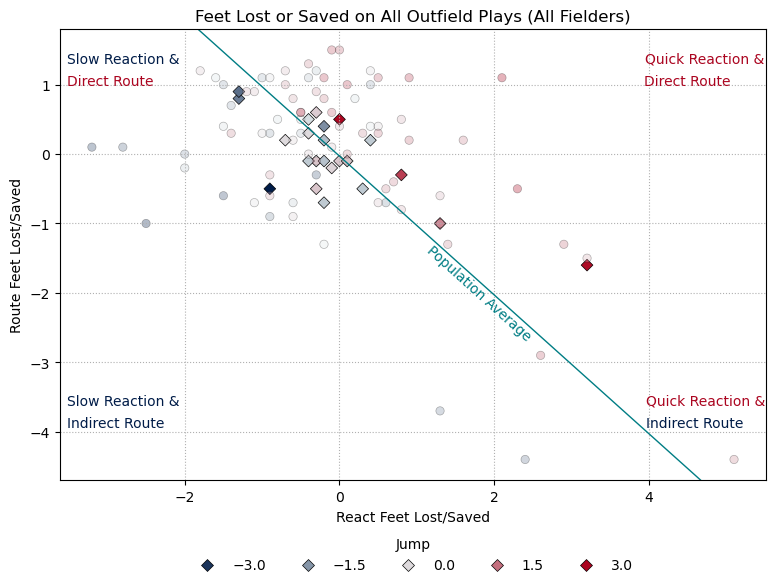

In [15]:
# Get the means of react and route for all players.
mean_react = players_comp_jump['mean_react'].mean()
mean_route = players_comp_jump['mean_route'].mean()

not_home_teams = qualified_players[~qualified_players['player_id'].isin(home_teams['player_id'])]

# Plot figure.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot fielders with 15+ opportunities.
sns.scatterplot(data = home_teams, x = 'mean_react', y = 'mean_route', hue = 'ft_v_avg', 
                palette = COLOR_MAP, edgecolor = 'black', marker='D', ax = ax)

# Plot all qualifying.
sns.scatterplot(data = not_home_teams, x = 'mean_react', y = 'mean_route', hue = 'ft_v_avg', 
                palette = COLOR_MAP, edgecolor = 'black', alpha = .3, ax = ax, legend = False)
 
# Add annotations.
# Top right.
plt.annotate('Quick Reaction &', xy = (.998, .95), xycoords = 'axes fraction', ha = 'right', va = 'top', color = '#AB0520')
plt.annotate('Direct Route', xy = (.95, .90), xycoords = 'axes fraction', ha = 'right', va = 'top', color = '#AB0520')

# Top left
plt.annotate('Slow Reaction &', xy = (.17, .95), xycoords = 'axes fraction', ha = 'right', va = 'top', color = '#001C48')
plt.annotate('Direct Route', xy = (.133, .90), xycoords = 'axes fraction', ha = 'right', va = 'top', color = '#AB0520')
    
# Bottom left.
plt.annotate('Slow Reaction &', xy = (.01, .16), xycoords = 'axes fraction', ha = 'left', va = 'bottom', color = '#001C48')
plt.annotate('Indirect Route', xy = (.01, .11), xycoords = 'axes fraction', ha = 'left', va = 'bottom', color = '#001C48')

# Bottom right
plt.annotate('Quick Reaction &', xy = (.83, .16), xycoords = 'axes fraction', ha = 'left', va = 'bottom', color = '#AB0520')
plt.annotate('Indirect Route', xy = (.83, .11), xycoords = 'axes fraction', ha = 'left', va = 'bottom', color = '#001C48')
    
# Plot the mean line, color turqoise.
plt.axline(xy1 = (mean_react, mean_route), slope = -1, linewidth = 1, color = '#007D84')
plt.text(1.80, -2, 'Population Average', rotation = -42, ha= 'center', va = 'center', color = '#007D84')
    
# Labels.
plt.title('Feet Lost or Saved on All Outfield Plays (All Fielders)')
plt.xlabel('React Feet Lost/Saved')
plt.ylabel('Route Feet Lost/Saved')
    
# Polish.
# Move legend to bottom and make horizontal with ncol.
plt.legend(loc = 'upper center', bbox_to_anchor = (.5, -.1), title = 'Jump', ncol = 6).set_frame_on(False)
plt.grid(linestyle = ':')
plt.tight_layout()
plt.show()

Examining the Jump of the fielder in this way can give insight into how players gain their Jump metric. Fielders that have both a high React and Route cover a large amount of distance in the first 1.5 seconds of the route and run direct routes to the ball's location. These types of fielders are further to right and higher up on the y-axis. Fielders that are located on the left and lower on the y-axis have both a slow reaction to the ball off the bat and indirect routes to getting to the balls. The players that are somewhere in the middle have an average reaction and mostly direct routes. Finally, the distance during the Burst phase can be inferred based on the value of the Jump metric. When a player is around average positioning but has a high Jump metric, this indicates the majority of their Jump metric comes from distance covered during their Burst phase.

Now let's take a look at who leads this population in Jump.

In [16]:
# List to change text color.
darks = ['#ab0520', '#19335a', '#ad0c26', '#294165', '#425777', '#7e8ea3', '#001c48']

# Normalize color map for Jump.
norm = CenteredNorm(vcenter = players_comp_jump['ft_v_avg'].median())

# Get color for each jump metric.
home_teams['color'] = home_teams['ft_v_avg'].map(lambda x: rgb2hex(COLOR_MAP(norm(x))))

# Get the text color based on color.
home_teams['text'] = np.where(home_teams['color'].isin(darks), 'white', 'black')

# Query to get the top and bottom five fielders for Jump.
query = """
-- CTE to get qualifying player oaa.
WITH oaa AS (SELECT player_id,
                    SUM(oaa) AS oaa
                    FROM route_metrics_oaa
                    WHERE star NOT IN ('0 Star', '1 Star')
                          AND player_id IN (SELECT player_id
                                            FROM home_teams)
                    GROUP BY player_id),
-- CTE to add oaa to other metrics.
players_oaa AS (SELECT ht.*,
                       o.oaa
                FROM home_teams AS ht
                JOIN oaa AS o
                ON ht.player_id = o.player_id
                ORDER BY ht.ft_v_avg DESC),
-- CTE to get players ranked by Jump.
ranked_jump AS (SELECT *,
                       ROW_NUMBER() OVER (ORDER BY ft_v_avg DESC) AS rank
                FROM players_oaa),
-- CTE to get the top fielders by Jump.
top_jump AS (SELECT player_id AS id_top,
                    oaa AS oaa_top,
                    mean_react AS mean_react_top,
                    mean_burst AS mean_burst_top,
                    mean_route AS mean_route_top,
                    ft_v_avg AS ft_v_avg_top,
                    color AS color_top,
                    text AS text_top,
                    rank AS rank_top,
                    ROW_NUMBER() OVER (ORDER BY rank) AS n_align
             FROM ranked_jump
             WHERE rank <= 5
             ORDER BY ft_v_avg ASC),
-- CTE to get the bottom fielders by Jump.
bot_jump AS (SELECT player_id AS id_bot,
                    oaa AS oaa_bot,
                    mean_react AS mean_react_bot,
                    mean_burst AS mean_burst_bot,
                    mean_route AS mean_route_bot,
                    ft_v_avg AS ft_v_avg_bot,
                    color AS color_bot,
                    text AS text_bot,
                    rank AS rank_bot,
                    ROW_NUMBER() OVER (ORDER BY rank) AS n_align
             FROM ranked_jump
             WHERE rank >= 19
             ORDER BY ft_v_avg ASC,
                      oaa ASC)
-- Table to put each fielder in specified row.
SELECT t.n_align,
       t.rank_top,
       t.id_top,
       ROUND(t.oaa_top, 1) AS oaa_top,
       t.mean_react_top,
       t.mean_burst_top,
       t.mean_route_top,
       t.ft_v_avg_top,
       t.color_top,
       t.text_top,
       b.rank_bot,
       b.id_bot,
       ROUND(b.oaa_bot, 1) AS oaa_bot,
       b.mean_react_bot,
       b.mean_burst_bot,
       b.mean_route_bot,
       b.ft_v_avg_bot,
       b.color_bot,
       b.text_bot
FROM top_jump AS t
JOIN bot_jump AS b
ON t.n_align = b.n_align
ORDER BY t.n_align
"""

top_bot_jump = queryDB(query)

In [17]:
# List of columns to hide and move to front.
hide_cols = ['n_align','color_bot', 'color_top', 'text_bot', 'text_top']

(GT(top_bot_jump)
  # Header
 .tab_header(title = 'Top and Bottom 5 Outfielders by Jump')
  # Top
 .tab_spanner(label = 'Top 5',
              columns = ['rank_top', 'id_top', 'oaa_top', 'mean_react_top', 'mean_burst_top', 'mean_route_top', 'ft_v_avg_top'])
  # Bot
 .tab_spanner(label = 'Bottom 5',
             columns = ['rank_bot', 'id_bot', 'oaa_bot', 'mean_react_bot', 'mean_burst_bot', 'mean_route_bot', 'ft_v_avg_bot'])
  # Format numbers.
 .fmt_number(columns = ['mean_react_bot', 'mean_burst_bot', 'mean_route_bot', 'mean_react_top', 'mean_burst_top', 'mean_route_top',
                        'ft_v_avg_bot', 'ft_v_avg_top'],
             decimals = 1)
  .tab_style(style.borders(sides = ['right'], color = 'black'),
                           locations = loc.body(columns = [1, 10]))
   # Create white space between columns.
 .tab_style(style.borders(sides = ['left'], color ='white', weight = '20px'),
                              locations = loc.body(columns=[10]))
 # Apply color map.
 .tab_style(style.fill(color = from_column(column = 'color_top')),
                       locations = loc.body(columns = 'ft_v_avg_top'))
 .tab_style(style.fill(color = from_column(column = 'color_bot')),
                       locations = loc.body(columns = 'ft_v_avg_bot'))
 # Change text of hard to read colors to white.
 .tab_style(style.text(color = from_column(column = 'text_top')),
                           locations = loc.body(columns = 'ft_v_avg_top'))
 .tab_style(style.text(color = from_column(column = 'text_bot')),
                           locations = loc.body(columns = 'ft_v_avg_bot'))
  # Label Columns
 .cols_label(rank_top = 'Rank',
             id_top = 'Fielder',
             oaa_top = 'OAA',
             mean_react_top = 'React',
             mean_burst_top = 'Burst',
             mean_route_top = 'Route',
             ft_v_avg_top = 'Feet v Avg',
             rank_bot = 'Rank',
             id_bot = 'Fielder',
             oaa_bot = 'OAA',
             mean_react_bot = 'React',
             mean_burst_bot = 'Burst',
             mean_route_bot = 'Route',
             ft_v_avg_bot = 'Feet v Avg',)
  # Hide and align.
 .cols_hide(hide_cols)
 .cols_align('center'))

GT(_tbl_data=   n_align  rank_top    id_top  oaa_top  mean_react_top  mean_burst_top  \
0        1         1  QEA-0252      2.1             0.0             2.5   
1        2         2  RZQ-0346      4.3             3.2             1.3   
2        3         3  YJD-0210      3.1             0.8             1.7   
3        4         4  YJD-0019      3.6             1.3             1.1   
4        5         5  YJD-0345      1.0             0.0             0.4   

   mean_route_top  ft_v_avg_top color_top text_top  rank_bot    id_bot  \
0             0.5           3.0   #ab0520    white        19  YJD-0185   
1            -1.6           2.9   #ad0c26    white        20  RZQ-0014   
2            -0.3           2.2   #bb475b    black        21  RZQ-0333   
3            -1.0           1.4   #cb8b97    black        22  QEA-0249   
4            -0.1           0.3   #e1e8ea    black        23  RZQ-0275   

   oaa_bot  mean_react_bot  mean_burst_bot  mean_route_bot  ft_v_avg_bot  \
0      0.0            -0.2            -0.9             0.2          -0.9   
1      0.1            -0.2            -1.8             0.4          -1.6   
2     -2.9            -1.3            -1.4             0.8          -1.9   
3     -0.9            -1.3            -1.7             0.9          -2.1   
4     -3.2            -0.9            -2.0            -0.5          -3.4   

  color_bot text_bot  
0   #7e8ea3    white  
1   #425777    white  
2   #294165    white  
3   #19335a    white  
4   #001c48    white  , _body=<great_tables._gt_data.Body object at 0x0000029B808A2B50>, _boxhead=Boxhead([ColInfo(var='n_align', type=<ColInfoTypeEnum.hidden: 4>, column_label='n_align', column_align='center', column_width=None), ColInfo(var='rank_top', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='center', column_width=None), ColInfo(var='id_top', type=<ColInfoTypeEnum.default: 1>, column_label='Fielder', column_align='center', column_width=None), ColInfo(var='oaa_top', type=<ColInfoTypeEnum.default: 1>, column_label='OAA', column_align='center', column_width=None), ColInfo(var='mean_react_top', type=<ColInfoTypeEnum.default: 1>, column_label='React', column_align='center', column_width=None), ColInfo(var='mean_burst_top', type=<ColInfoTypeEnum.default: 1>, column_label='Burst', column_align='center', column_width=None), ColInfo(var='mean_route_top', type=<ColInfoTypeEnum.default: 1>, column_label='Route', column_align='center', column_width=None), ColInfo(var='ft_v_avg_top', type=<ColInfoTypeEnum.default: 1>, column_label='Feet v Avg', column_align='center', column_width=None), ColInfo(var='color_top', type=<ColInfoTypeEnum.hidden: 4>, column_label='color_top', column_align='center', column_width=None), ColInfo(var='text_top', type=<ColInfoTypeEnum.hidden: 4>, column_label='text_top', column_align='center', column_width=None), ColInfo(var='rank_bot', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='center', column_width=None), ColInfo(var='id_bot', type=<ColInfoTypeEnum.default: 1>, column_label='Fielder', column_align='center', column_width=None), ColInfo(var='oaa_bot', type=<ColInfoTypeEnum.default: 1>, column_label='OAA', column_align='center', column_width=None), ColInfo(var='mean_react_bot', type=<ColInfoTypeEnum.default: 1>, column_label='React', column_align='center', column_width=None), ColInfo(var='mean_burst_bot', type=<ColInfoTypeEnum.default: 1>, column_label='Burst', column_align='center', column_width=None), ColInfo(var='mean_route_bot', type=<ColInfoTypeEnum.default: 1>, column_label='Route', column_align='center', column_width=None), ColInfo(var='ft_v_avg_bot', type=<ColInfoTypeEnum.default: 1>, column_label='Feet v Avg', column_align='center', column_width=None), ColInfo(var='color_bot', type=<ColInfoTypeEnum.hidden: 4>, column_label='color_bot', column_align='center', column_width=None), ColInfo(var='text_bot', type=<ColInfoTypeEnum.hidden: 4>, column_label='text_bot', column_align='center', column_width=None)

Outfielder QEA-0252 has the highest Jump metric traveling the most during their Burst phase and running a direct Route. The next highest Jump metric is with RZQ-0346 with the majority of their route occurring during the React phase and running an indirect route. QEA-0252 has an average Reaction to the ball off the bat and is able to use their speed to get to the batted ball location, running a fairly indirect route, whereas RZQ-0346 has a quick Reaction to the ball of the bat and utilizes their speed in the Burst phase to make up the distance traveled in the wrong direction, running an indirect route. Based on these three components of the Jump, there is already a clearer picture on what type of outfielder each of these examples are.

Looking at the bottom 5 outfielders by Jump, they are all below average on distance traveled in all phases but run rather direct routes. The only outfielder in the top 5 by Jump to run a direct route is QEA-0252. They also have the second lowest OAA of the top 5 outfielders.

Could different components of the Jump be better predictors of OAA?

### Jump Components and OAA

Text(0.5, 1.0, 'Heatmap of Jump Components and OAA')

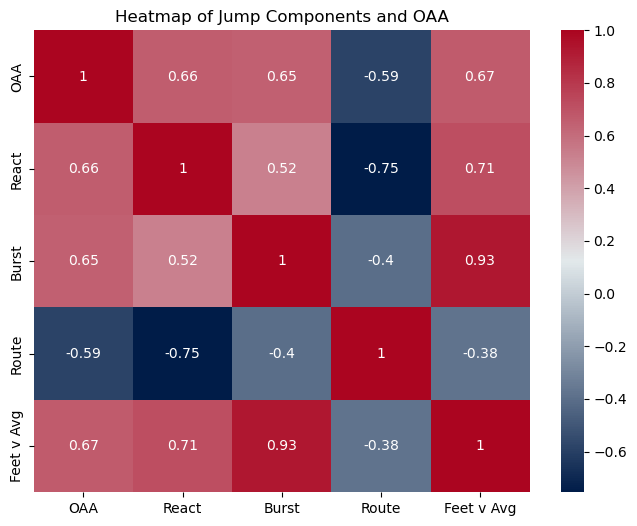

In [18]:
# Query to get OAA for the qualified players.
query = """
-- CTE to get qualifying player oaa.
WITH oaa AS (SELECT player_id,
                    SUM(oaa) AS oaa
             FROM route_metrics_oaa
             WHERE star NOT IN ('0 Star', '1 Star')
                   AND player_id IN (SELECT player_id
                                     FROM home_teams)
             GROUP BY player_id)
-- CTE to add oaa to other metrics.
SELECT ht.*,
        o.oaa
FROM home_teams AS ht
JOIN oaa AS o
ON ht.player_id = o.player_id
"""

# Returns table with oaa and jump metrics.
jump_oaa = queryDB(query)

# Initialize list of feats used in correlation.
corr_feats = ['oaa', 'mean_react', 'mean_burst', 'mean_route', 'ft_v_avg']

# Apply filter.
jump_oaa_corr = jump_oaa[corr_feats]

# Rename columns for figure.
jump_oaa_corr= jump_oaa_corr.rename(columns = {'oaa': 'OAA',
                                               'opps': 'Opps',
                                               'mean_react': 'React',
                                               'mean_burst': 'Burst',
                                               'mean_route': 'Route',
                                               'ft_v_avg': 'Feet v Avg'})

# Get correlation Matrix.
jump_oaa_matrix = jump_oaa_corr.corr()

# Plot Heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(jump_oaa_matrix, annot = True, cmap = COLOR_MAP)
plt.title('Heatmap of Jump Components and OAA')

The Jump component with the strongest correlation is Route. Route has a strong negative correlation to OAA, meaning that the closer that the outfielder's accumulative distance is to the direct distance needed to catch the ball, the lower the outfielder's OAA will be. Coincidentally, the strongest correlation to Route is React with a strong negative correlation. Intuitively this makes sense. At the beginning of the route, the outfielder has less information about where the ball will end up, so the distance that they are traveling would most likely be indirect to where the ball will end up. However, due to the relatively strong correlations between the distance metrics that track distance in any direction and OAA, this would suggest that movement in any direction is more important to OAA than reading exactly where the ball will be to take the best route.

### Jump, Intensity, and OAA

Converting balls into outs is about more than running fast. It is about starting to move as soon as you possibly can.

The components of Jump break down what parts of the route the outfielder is covering the most ground. Greater route distances than the minimum needed having a positive effect on OAA. Additionally, the greater the distance covered in the React phase, the less direct the route becomes. And what is route intensity if not an indication that the fielder is covering the most distance for the longest amount of time that they can? High intensity routes accounted for 65% of all outs made at 3+ Star difficulties. At these same difficulty levels, it was also observed that the average OAA gained increase by 0.2 at each increase of play difficulty.

What is important to accumulating OAA is that the fielder covers distance, regardless of the direction. This is seen with Route’s strong negative correlation to OAA and positive correlation with Jump components that measure the amount of distance in any direction. 

So instead of just telling players to catch more balls, we can tell them to move early and often.